# Задание 3
## Цель задания
* Обработка кардиологического дата-сета для решения задач бинарной классификации
## Ключевой навык
* Применение AutoML моделей, расчет точности классификатора
## Датасет
* Необходимо загрузить датасет, расположенный по адресу (см. файлы с названием «модуль 3….»): https://github.com/AI-is-out-there/data2lab.git.
## Задание
1.	Сформировать обучающую выборку из загруженного датасета, состоящую из столбцов: ['Count_subj', 'rr_interval', 'p_end',  'qrs_onset', 'qrs_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status’]. Датасет состоит из числовых параметров ЭКГ и классификационного признака Healthy_Status. 
2.	Используя выбранные ранее решения AutoML, найдите наиболее эффективное, используя такие метрика качества как: матрица ошибок (confusion matrix) и F1-метрика для оценки обученного классификатора по признаку Healthy_Status на основе данных параметров ЭКГ. 
3.	Усовершенствуйте решения за счет предобработки исходных данных
4.	Проверьте свои модели на тестовой и валидационной выборке.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

from fedot.api.main import Fedot
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
import h2o
from h2o.automl import H2OAutoML

import joblib
from fastapi import FastAPI
from pydantic import BaseModel
import uvicorn
from threading import Thread

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Формирование обучающей выборки
df = pd.read_csv('data.csv')
cols = ['Count_subj', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']
df = df[cols]
df.head()

,Count_subj,rr_interval,p_end,qrs_onset,qrs_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,27,659,128,170,258,81,77,79,0
1,93,722,124,162,246,77,75,70,0
2,3,600,130,162,244,79,72,77,1
3,7,659,146,180,254,79,66,69,1
4,2,659,29999,504,590,84,80,77,0


In [3]:
# Разделение на обучающую и тестовую части
X = df.drop(columns=['Healthy_Status'])
y = df['Healthy_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [27]:
# Результаты обучения
results = []

In [28]:
# FEDOT
fedot_model = Fedot(problem='classification', timeout=5)
fedot_model.fit(features=X_train, target=y_train)
fedot_preds = fedot_model.predict(features=X_test)

fedot_f1_macro = f1_score(y_test, fedot_preds, average='macro')
fedot_f1_weighted = f1_score(y_test, fedot_preds, average='weighted')
fedot_cm = confusion_matrix(y_test, fedot_preds)

results.append({
    'AutoML': 'FEDOT',
    'F1 Macro': fedot_f1_macro,
    'F1 Weighted': fedot_f1_weighted,
    'Confusion Matrix': fedot_cm
})

2025-04-21 01:41:40,547 - ApiComposer - Initial pipeline was fitted in 1.6 sec.
2025-04-21 01:41:40,550 - ApiComposer - Taking into account n_folds=5, estimated fit time for initial assumption is 7.9 sec.
2025-04-21 01:41:40,551 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2025-04-21 01:41:40,559 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 5 min. Set of candidate models: ['bernb', 'catboost', 'dt', 'fast_ica', 'isolation_forest_class', 'knn', 'lgbm', 'logit', 'mlp', 'normalization', 'pca', 'poly_features', 'qda', 'resample', 'rf', 'scaling', 'xgboost'].
2025-04-21 01:41:40,657 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 0/10000 [00:00<?, ?gen/s]

2025-04-21 01:41:53,054 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-04-21 01:41:53,054 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-04-21 01:41:53,054 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-04-21 01:41:53,054 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-04-21 01:41:53,054 - Topological features operation requires extra dependencies for time series forecasting, which 

Generations:   0%|          | 1/10000 [00:57<160:38:49, 57.84s/gen]

2025-04-21 01:42:41,514 - MultiprocessingDispatcher - 12 individuals out of 12 in previous population were evaluated successfully.
2025-04-21 01:42:42,150 - MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


Generations:   0%|          | 2/10000 [01:01<71:58:47, 25.92s/gen] 

2025-04-21 01:42:46,793 - MultiprocessingDispatcher - 18 individuals out of 18 in previous population were evaluated successfully.
2025-04-21 01:42:51,648 - MultiprocessingDispatcher - 12 individuals out of 13 in previous population were evaluated successfully.
2025-04-21 01:42:51,954 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.


Generations:   0%|          | 3/10000 [01:11<51:32:35, 18.56s/gen]

2025-04-21 01:42:55,279 - MultiprocessingDispatcher - 30 individuals out of 32 in previous population were evaluated successfully.
2025-04-21 01:42:58,632 - MultiprocessingDispatcher - 22 individuals out of 22 in previous population were evaluated successfully.
2025-04-21 01:42:59,175 - MultiprocessingDispatcher - 5 individuals out of 6 in previous population were evaluated successfully.
2025-04-21 01:42:59,190 - MultiprocessingDispatcher - 11 individuals out of 11 in previous population were evaluated successfully.


Generations:   0%|          | 4/10000 [01:18<39:07:06, 14.09s/gen]

2025-04-21 01:43:01,968 - MultiprocessingDispatcher - 9 individuals out of 9 in previous population were evaluated successfully.
2025-04-21 01:43:18,889 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.


Generations:   0%|          | 5/10000 [01:38<44:44:00, 16.11s/gen]

2025-04-21 01:43:35,510 - MultiprocessingDispatcher - 9 individuals out of 9 in previous population were evaluated successfully.
2025-04-21 01:43:36,672 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.


Generations:   0%|          | 6/10000 [01:55<46:18:22, 16.68s/gen]

2025-04-21 01:43:40,523 - MultiprocessingDispatcher - 10 individuals out of 10 in previous population were evaluated successfully.


Generations:   0%|          | 7/10000 [01:59<34:39:32, 12.49s/gen]

2025-04-21 01:43:41,475 - MultiprocessingDispatcher - 8 individuals out of 9 in previous population were evaluated successfully.
2025-04-21 01:43:41,778 - MultiprocessingDispatcher - 3 individuals out of 4 in previous population were evaluated successfully.


Generations:   0%|          | 8/10000 [02:01<24:43:55,  8.91s/gen]

2025-04-21 01:43:42,209 - MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.
2025-04-21 01:43:42,609 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2025-04-21 01:43:43,615 - MultiprocessingDispatcher - 5 individuals out of 5 in previous population were evaluated successfully.


Generations:   0%|          | 9/10000 [02:02<18:35:28,  6.70s/gen]

2025-04-21 01:43:44,916 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2025-04-21 01:43:45,462 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.


Generations:   0%|          | 10/10000 [02:04<14:26:00,  5.20s/gen]

2025-04-21 01:43:45,928 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2025-04-21 01:43:48,544 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.


Generations:   0%|          | 11/10000 [02:07<12:37:56,  4.55s/gen]

2025-04-21 01:43:50,705 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2025-04-21 01:43:52,630 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.


Generations:   0%|          | 12/10000 [02:11<12:14:13,  4.41s/gen]

2025-04-21 01:43:54,636 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2025-04-21 01:43:56,610 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.


Generations:   0%|          | 13/10000 [02:15<11:52:29,  4.28s/gen]

2025-04-21 01:43:57,149 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2025-04-21 01:43:57,825 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2025-04-21 01:43:58,235 - MultiprocessingDispatcher - 5 individuals out of 5 in previous population were evaluated successfully.


Generations:   0%|          | 14/10000 [02:17<9:38:50,  3.48s/gen] 

2025-04-21 01:43:58,805 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2025-04-21 01:43:59,578 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.


Generations:   0%|          | 15/10000 [02:18<7:51:44,  2.83s/gen]

2025-04-21 01:44:01,442 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2025-04-21 01:44:01,855 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.


Generations:   0%|          | 16/10000 [02:21<7:23:45,  2.67s/gen]

2025-04-21 01:44:21,000 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2025-04-21 01:44:21,630 - MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.


Generations:   0%|          | 17/10000 [02:40<21:39:42,  7.81s/gen]

2025-04-21 01:44:24,288 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2025-04-21 01:44:26,825 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.


Generations:   0%|          | 18/10000 [02:46<19:28:47,  7.03s/gen]

2025-04-21 01:44:27,349 - MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
2025-04-21 01:44:27,922 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2025-04-21 01:44:28,278 - MultiprocessingDispatcher - 5 individuals out of 5 in previous population were evaluated successfully.


Generations:   0%|          | 19/10000 [02:47<14:50:10,  5.35s/gen]

2025-04-21 01:44:28,712 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2025-04-21 01:44:29,133 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.


Generations:   0%|          | 20/10000 [02:48<11:05:32,  4.00s/gen]

2025-04-21 01:44:29,498 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2025-04-21 01:44:29,816 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.


Generations:   0%|          | 21/10000 [02:49<8:19:49,  3.01s/gen] 

2025-04-21 01:44:30,167 - MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
2025-04-21 01:44:30,744 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.


Generations:   0%|          | 22/10000 [02:50<6:36:07,  2.38s/gen]

2025-04-21 01:44:31,067 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2025-04-21 01:44:31,795 - MultiprocessingDispatcher - 3 individuals out of 4 in previous population were evaluated successfully.
2025-04-21 01:44:32,184 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.


Generations:   0%|          | 23/10000 [02:51<5:49:04,  2.10s/gen]

2025-04-21 01:44:34,216 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2025-04-21 01:44:36,975 - MultiprocessingDispatcher - 2 individuals out of 3 in previous population were evaluated successfully.
2025-04-21 01:44:37,495 - MultiprocessingDispatcher - 3 individuals out of 5 in previous population were evaluated successfully.


Generations:   0%|          | 24/10000 [02:56<8:29:11,  3.06s/gen]

2025-04-21 01:44:37,500 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 24/10000 [02:56<20:24:33,  7.36s/gen]

2025-04-21 01:44:37,574 - ApiComposer - Hyperparameters tuning started with 2 min. timeout


2025-04-21 01:44:40,947 - SimultaneousTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [catboost]}
catboost - {'n_jobs': 1, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': False, 'allow_writing_files': False, 'use_eval_set': True, 'use_best_model': True, 'enable_categorical': True} 
Initial metric: [0.911]
  0%|          | 265/100000 [01:57<12:20:09,  2.25trial/s, best loss: inf]
2025-04-21 01:46:39,310 - SimultaneousTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [catboost]}
catboost - {'n_jobs': 1, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 

In [29]:
# LAMA
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

task = Task('binary') 
automl = TabularAutoML(task, timeout=300, cpu_limit=1)
oof_pred = automl.fit_predict(train_data, roles={'target': 'Healthy_Status'})
test_pred = automl.predict(test_data).data[:, 0]

test_pred_labels = (test_pred > 0.5).astype(int)
lama_f1_macro = f1_score(y_test, test_pred_labels, average='macro')
lama_f1_weighted = f1_score(y_test, test_pred_labels, average='weighted')
lama_cm = confusion_matrix(y_test, test_pred_labels)

results.append({
    'AutoML': 'LightAutoML',
    'F1 Macro': lama_f1_macro,
    'F1 Weighted': lama_f1_weighted,
    'Confusion Matrix': lama_cm
})

In [30]:
# H2O AutoML
h2o.init()

train_df = X_train.copy()
train_df['Healthy_Status'] = y_train.values

train_h2o = h2o.H2OFrame(train_df)
test_h2o = h2o.H2OFrame(X_test)

target = 'Healthy_Status'
features = [col for col in train_h2o.columns if col != target]

train_h2o[target] = train_h2o[target].asfactor()

aml = H2OAutoML(
    max_runtime_secs=300,
    max_models=20,
    seed=42,
    sort_metric='AUTO',
    nfolds=5
)

aml.train(x=features, y=target, training_frame=train_h2o)

preds = aml.leader.predict(test_h2o).as_data_frame()
y_pred = preds['predict']

h2o_f1_macro = f1_score(y_test, y_pred, average='macro')
h2o_f1_weighted = f1_score(y_test, y_pred, average='weighted')
h2o_cm = confusion_matrix(y_test, y_pred)

results.append({
    'AutoML': 'H2O',
    'F1 Macro': h2o_f1_macro,
    'F1 Weighted': h2o_f1_weighted,
    'Confusion Matrix': h2o_cm
})

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,6 hours 24 mins
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_timerlan_uut7hj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.840 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
01:48:24.327: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


        AutoML  F1 Macro  F1 Weighted
0        FEDOT  0.770166     0.850750
1  LightAutoML  0.758031     0.845043
2          H2O  0.787243     0.856236


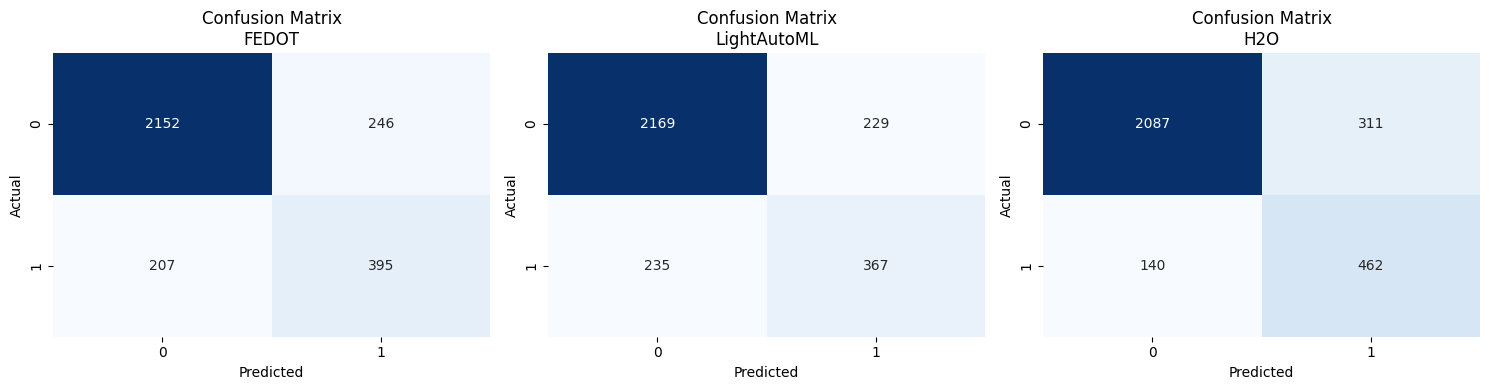

In [31]:
results_df = pd.DataFrame(results).drop(columns=['Confusion Matrix'])
print(results_df)

n_models = len(results)
fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 4))

if n_models == 1:
    axes = [axes]

for ax, r in zip(axes, results):
    cm = r['Confusion Matrix']
    automl_name = r['AutoML']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'Confusion Matrix\n{automl_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [5]:
# Предобработка данных
cols = [col for col in df.columns if col != 'Healthy_Status']
X_train_transformed = X_train
X_test_transformed = X_test
y_train_transformed = y_train

# Удаляем выбросы по Z-оценке в обучающей выборке
z_scores = np.abs(X_train_transformed.apply(zscore))
X_train_transformed = X_train[(z_scores < 3).all(axis=1)].copy()
y_train_transformed = y_train[X_train_transformed.index]

# Не повышает точность

# Масштабируем данные
# scaler = MinMaxScaler()
# X_train_transformed = pd.DataFrame(scaler.fit_transform(X_train_transformed), columns=cols)
# X_test_transformed = pd.DataFrame(scaler.fit_transform(X_test), columns=cols)

# # Удаляем сильно коррелирующие признаки (>0.9)
# corr_matrix = X_train_filtered.corr().abs()
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
# X_train_filtered.drop(columns=to_drop, inplace=True)
# X_test_scaled = X_test_scaled.drop(columns=to_drop)

# Балансируем классы SMOTE (только для обучающей выборки)
smote = SMOTE(random_state=42)
X_train_transformed, y_train_transformed = smote.fit_resample(X_train_transformed, y_train_transformed)

In [10]:
results_transformed = []

In [40]:
# FEDOT
fedot_model = Fedot(problem='classification', timeout=5)
fedot_model.fit(features=X_train_transformed, target=y_train_transformed)
fedot_preds = fedot_model.predict(features=X_test_transformed)

fedot_f1_macro = f1_score(y_test, fedot_preds, average='macro')
fedot_f1_weighted = f1_score(y_test, fedot_preds, average='weighted')
fedot_cm = confusion_matrix(y_test, fedot_preds)

results_transformed.append({
    'AutoML': 'FEDOT',
    'F1 Macro': fedot_f1_macro,
    'F1 Weighted': fedot_f1_weighted,
    'Confusion Matrix': fedot_cm
})

2025-04-21 04:02:39,422 - ApiComposer - Initial pipeline was fitted in 4.4 sec.
2025-04-21 04:02:39,428 - ApiComposer - Taking into account n_folds=5, estimated fit time for initial assumption is 22.2 sec.
2025-04-21 04:02:39,432 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2025-04-21 04:02:39,447 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 5 min. Set of candidate models: ['bernb', 'catboost', 'dt', 'fast_ica', 'isolation_forest_class', 'knn', 'lgbm', 'logit', 'mlp', 'normalization', 'pca', 'poly_features', 'qda', 'resample', 'rf', 'scaling', 'xgboost'].
2025-04-21 04:02:39,546 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 0/10000 [00:00<?, ?gen/s]

2025-04-21 04:02:52,303 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-04-21 04:02:52,303 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-04-21 04:02:52,303 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-04-21 04:02:52,303 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-04-21 04:02:52,303 - Topological features operation requires extra dependencies for time series forecasting, which 

ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/Users/timerlan/Desktop/StudyProjects/4/PPA/.venv/lib/python3.9/site-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
  File "/Users/timerlan/Desktop/StudyProjects/4/PPA/.venv/lib/python3.9/site-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
  File "/Users/timerlan/Desktop/StudyProjects/4/PPA/.venv/lib/python3.9/site-packages/fastapi/applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "/Users/timerlan/Desktop/StudyProjects/4/PPA/.venv/lib/python3.9/site-packages/starlette/applications.py", line 112, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/Users/timerlan/Desktop/StudyProjects/4/PPA/.venv/lib/python3.9/site-packages/starlette/middleware/errors.py", line 187, in __call__
    raise ex

INFO:     127.0.0.1:64126 - "GET /metrics HTTP/1.1" 307 Temporary Redirect
INFO:     127.0.0.1:64126 - "GET /metrics/ HTTP/1.1" 500 Internal Server Error


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/Users/timerlan/Desktop/StudyProjects/4/PPA/.venv/lib/python3.9/site-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
  File "/Users/timerlan/Desktop/StudyProjects/4/PPA/.venv/lib/python3.9/site-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
  File "/Users/timerlan/Desktop/StudyProjects/4/PPA/.venv/lib/python3.9/site-packages/fastapi/applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "/Users/timerlan/Desktop/StudyProjects/4/PPA/.venv/lib/python3.9/site-packages/starlette/applications.py", line 112, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/Users/timerlan/Desktop/StudyProjects/4/PPA/.venv/lib/python3.9/site-packages/starlette/middleware/errors.py", line 187, in __call__
    raise ex

Generations:   0%|          | 1/10000 [01:10<196:17:41, 70.67s/gen]

2025-04-21 04:19:59,080 - MultiprocessingDispatcher - 24 individuals out of 29 in previous population were evaluated successfully.


Generations:   0%|          | 2/10000 [33:06<3211:09:32, 1156.25s/gen]

2025-04-21 04:35:46,540 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 2/10000 [33:06<2758:59:42, 993.44s/gen] 

2025-04-21 04:35:46,651 - ApiComposer - Time for pipeline composing was 0:33:06.999290.
The remaining 28.2 seconds are not enough to tune the hyperparameters.
2025-04-21 04:35:46,652 - ApiComposer - Composed pipeline returned without tuning.


2025-04-21 04:35:46,927 - ApiComposer - Model generation finished
2025-04-21 04:35:48,522 - FEDOT logger - Final pipeline was fitted
2025-04-21 04:35:48,523 - FEDOT logger - Final pipeline: {'depth': 1, 'length': 1, 'nodes': [rf]}
rf - {'n_jobs': 8}


In [15]:
# LAMA
train_data = pd.concat([X_train_transformed, y_train_transformed], axis=1)
test_data = pd.concat([X_test_transformed, y_test], axis=1)

task = Task('binary') 
automl = TabularAutoML(task, timeout=300, cpu_limit=1)
oof_pred = automl.fit_predict(train_data, roles={'target': 'Healthy_Status'})
test_pred = automl.predict(test_data).data[:, 0]

test_pred_labels = (test_pred > 0.5).astype(int)
lama_f1_macro = f1_score(y_test, test_pred_labels, average='macro')
lama_f1_weighted = f1_score(y_test, test_pred_labels, average='weighted')
lama_cm = confusion_matrix(y_test, test_pred_labels)

results_transformed.append({
    'AutoML': 'LightAutoML',
    'F1 Macro': lama_f1_macro,
    'F1 Weighted': lama_f1_weighted,
    'Confusion Matrix': lama_cm
})

In [16]:
# H2O AutoML
h2o.init()

train_df = X_train_transformed.copy()
train_df['Healthy_Status'] = y_train_transformed.values

train_h2o = h2o.H2OFrame(train_df)
test_h2o = h2o.H2OFrame(X_test_transformed)

target = 'Healthy_Status'
features = [col for col in train_h2o.columns if col != target]

train_h2o[target] = train_h2o[target].asfactor()

aml = H2OAutoML(
    max_runtime_secs=300,
    max_models=20,
    seed=42,
    sort_metric='AUTO',
    nfolds=5
)

aml.train(x=features, y=target, training_frame=train_h2o)

preds = aml.leader.predict(test_h2o).as_data_frame()
y_pred = preds['predict']

h2o_f1_macro = f1_score(y_test, y_pred, average='macro')
h2o_f1_weighted = f1_score(y_test, y_pred, average='weighted')
h2o_cm = confusion_matrix(y_test, y_pred)

results_transformed.append({
    'AutoML': 'H2O',
    'F1 Macro': h2o_f1_macro,
    'F1 Weighted': h2o_f1_weighted,
    'Confusion Matrix': h2o_cm
})

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,21 mins 47 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_timerlan_uut7hj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.896 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
19:45:31.492: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


        AutoML  F1 Macro  F1 Weighted
0        FEDOT  0.801424     0.861023
1  LightAutoML  0.782671     0.854187
2          H2O  0.773376     0.851749


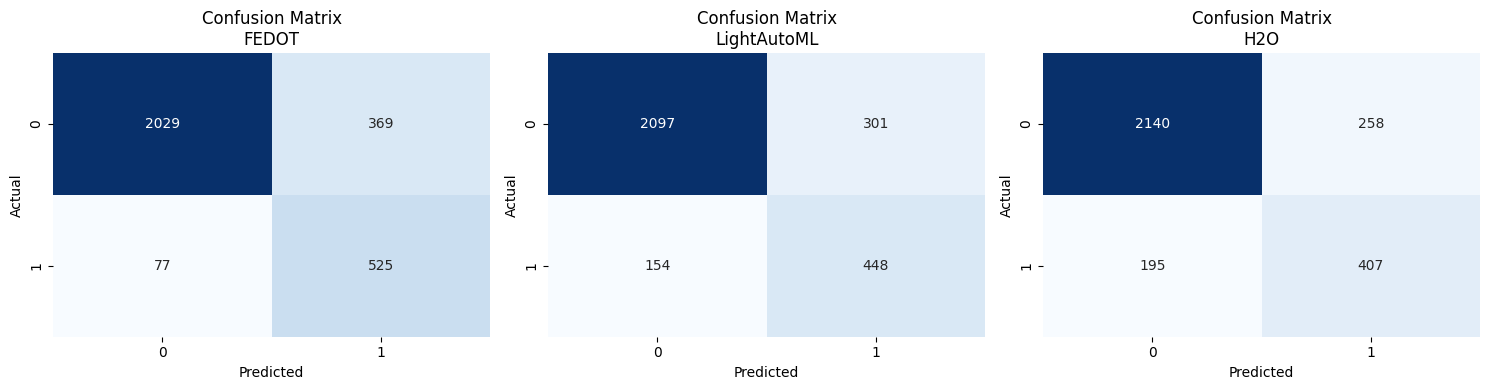

In [20]:
results_df = pd.DataFrame(results_transformed).drop(columns=['Confusion Matrix'])
print(results_df)

n_models = len(results_transformed)
fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 4))

if n_models == 1:
    axes = [axes]

for ax, r in zip(axes, results_transformed):
    cm = r['Confusion Matrix']
    automl_name = r['AutoML']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'Confusion Matrix\n{automl_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [35]:
# Сохраняем дамп лучшей модели
joblib.dump(fedot_model, 'fedot_model.pkl')

['fedot_model.pkl']

In [ ]:
# Загрузка модели
model_path = 'fedot_model.pkl'
fedot_model = joblib.load(model_path)

# Создание приложения FastAPI
app = FastAPI()

# Определение модели данных
class DataInput(BaseModel):
    features: list  # Список с признаками

# Создание endpoint для получения предсказания
@app.post("/predict/")
async def predict(data: DataInput):
    features = np.array(data.features).reshape(1, -1)  # Преобразование данных в нужный формат
    prediction = fedot_model.predict(features=features)  # Получение предсказания
    return {"prediction": prediction.tolist()}

# Пример endpoint для получения метрик F1 и матрицы ошибок
@app.get("/metrics/")
async def get_metrics():
    # Предсказания для теста
    fedot_preds = fedot_model.predict(features=X_test_transformed)
    fedot_f1_macro = f1_score(y_test, fedot_preds, average='macro')
    fedot_f1_weighted = f1_score(y_test, fedot_preds, average='weighted')
    fedot_cm = confusion_matrix(y_test, fedot_preds)

    return {
        "F1 Macro": fedot_f1_macro,
        "F1 Weighted": fedot_f1_weighted,
        "Confusion Matrix": fedot_cm.tolist()
    }

# Запускаем приложение
def run_uvicorn():
    uvicorn.run(app, host="0.0.0.0", port=8000)

# Запускаем сервер FastAPI в отдельном потоке
server_thread = Thread(target=run_uvicorn)
server_thread.start()

print("Server is running at http://127.0.0.1:8000")

Server is running at http://127.0.0.1:8000


INFO:     Started server process [88679]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:62907 - "GET /metrics HTTP/1.1" 307 Temporary Redirect
INFO:     127.0.0.1:62907 - "GET /metrics/ HTTP/1.1" 500 Internal Server Error


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/Users/timerlan/Desktop/StudyProjects/4/PPA/.venv/lib/python3.9/site-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
  File "/Users/timerlan/Desktop/StudyProjects/4/PPA/.venv/lib/python3.9/site-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
  File "/Users/timerlan/Desktop/StudyProjects/4/PPA/.venv/lib/python3.9/site-packages/fastapi/applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "/Users/timerlan/Desktop/StudyProjects/4/PPA/.venv/lib/python3.9/site-packages/starlette/applications.py", line 112, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/Users/timerlan/Desktop/StudyProjects/4/PPA/.venv/lib/python3.9/site-packages/starlette/middleware/errors.py", line 187, in __call__
    raise ex

INFO:     127.0.0.1:62925 - "GET /metrics HTTP/1.1" 307 Temporary Redirect
INFO:     127.0.0.1:62925 - "GET /metrics/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:62933 - "GET /predict HTTP/1.1" 307 Temporary Redirect
INFO:     127.0.0.1:62933 - "GET /predict/ HTTP/1.1" 405 Method Not Allowed
INFO:     127.0.0.1:62945 - "POST /predict HTTP/1.1" 307 Temporary Redirect
INFO:     127.0.0.1:62945 - "POST /predict/ HTTP/1.1" 422 Unprocessable Entity
INFO:     127.0.0.1:62980 - "POST /predict HTTP/1.1" 307 Temporary Redirect
INFO:     127.0.0.1:62980 - "POST /predict/ HTTP/1.1" 422 Unprocessable Entity
INFO:     127.0.0.1:62992 - "POST /predict HTTP/1.1" 307 Temporary Redirect
INFO:     127.0.0.1:62992 - "POST /predict/ HTTP/1.1" 500 Internal Server Error


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/Users/timerlan/Desktop/StudyProjects/4/PPA/.venv/lib/python3.9/site-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
  File "/Users/timerlan/Desktop/StudyProjects/4/PPA/.venv/lib/python3.9/site-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
  File "/Users/timerlan/Desktop/StudyProjects/4/PPA/.venv/lib/python3.9/site-packages/fastapi/applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "/Users/timerlan/Desktop/StudyProjects/4/PPA/.venv/lib/python3.9/site-packages/starlette/applications.py", line 112, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/Users/timerlan/Desktop/StudyProjects/4/PPA/.venv/lib/python3.9/site-packages/starlette/middleware/errors.py", line 187, in __call__
    raise ex

INFO:     127.0.0.1:63012 - "POST /predict HTTP/1.1" 307 Temporary Redirect
INFO:     127.0.0.1:63012 - "POST /predict/ HTTP/1.1" 422 Unprocessable Entity
INFO:     127.0.0.1:63021 - "POST /predict HTTP/1.1" 307 Temporary Redirect
INFO:     127.0.0.1:63021 - "POST /predict/ HTTP/1.1" 200 OK
